# Stats and summaries

This is a helper notebook for custom visualisation of stats exported from wandb.

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

FIGURES_DIR = Path("figures")
STATS_DIR_CLEAN = Path("stats/clean")

FIGURES_DIR.mkdir(exist_ok=True)
STATS_DIR_CLEAN.mkdir(exist_ok=True, parents=True)

Wandb setup:

In [2]:
import os
import wandb

api_key = os.getenv("WANDB_API_KEY")
if not api_key:
    wandb.login()
api = wandb.Api(api_key=api_key)

wandb: Currently logged in as: miglec (miglec-n-a) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


## n-CPS

### n-CPS n=2 learning rate and weight decay sweep

Collecting data from wandb:

In [3]:
# miglec: Started getting HTTP error on this one, not sure what's the problem
# Skip it, data is already collected
if False:
    # Filter by tag
    runs = api.runs(
        "DL-gr82/semi-supervised-ensembles",
        filters={"tags": "ncps-gcn-n2-lr"}
    )

    # Extract data
    target_epoch = 349
    data = []
    for run in runs:
        # Need to take epoch 350 as first runs were longer
        history = run.history()
        epoch_data = history.iloc[target_epoch]
        data.append({
            "run_id": run.id,
            "run_name": run.name,
            "seed": run.config["seed"],
            "val_mse": epoch_data["val_MSE"],
            "model": run.config["model"]["init"]["_target_"],
            "cps_loss_weight": run.config["trainer"]["init"]["cps_loss_weight"],
            "lr": run.config["trainer"]["init"]["optimizer"][0]["lr"],
            "weight_decay": run.config["trainer"]["init"]["optimizer"][0]["weight_decay"],
            "num_models": run.config["trainer"]["num_models"],
        })
    df = pd.DataFrame(data)
    out = STATS_DIR_CLEAN / "ncps-gcn-n2-lr-wd-sweep.csv"
    df.to_csv(out)

Plot n-CPS with n = 2 learning rate and weight decay sweep:

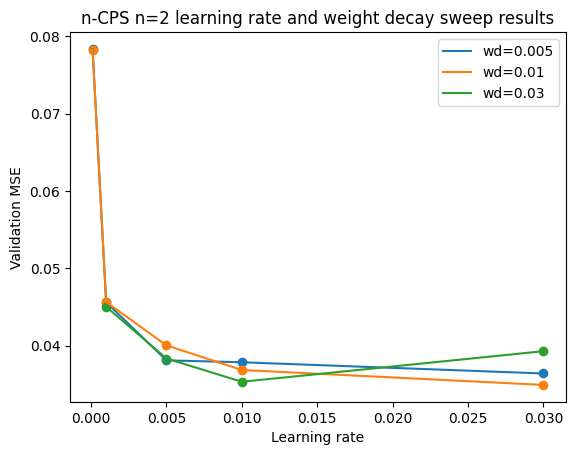

In [4]:
df = pd.read_csv(STATS_DIR_CLEAN / "ncps-gcn-n2-lr-wd-sweep.csv", quotechar="\"")

df = df.sort_values(by="lr")
fig, ax = plt.subplots()
ax.set_title("n-CPS n=2 learning rate and weight decay sweep results")
for wd in df["weight_decay"].unique():
    df_sub = df[df["weight_decay"] == wd]
    ax.scatter(df_sub["lr"], df_sub["val_mse"])
    ax.plot(df_sub["lr"], df_sub["val_mse"], label=f"wd={wd}")
    ax.set_xlabel("Learning rate")
    ax.set_ylabel("Validation MSE")
plt.savefig(FIGURES_DIR / "ncps-gcn-n2-lr-wd-sweep.png")
plt.legend();

n-CPS with n = 2 CPS loss weight $\lambda$ sweep results:

In [5]:
# Filter by tag
runs = api.runs(
    "DL-gr82/semi-supervised-ensembles",
    filters={
        "tags": "ncps-gcn-n2-lambda-sweep",
        "state": "finished"
    }
)

# Extract data
data = []
print(f"Runs found: {len(runs)}")
for run in runs:
    opt = run.config["trainer"]["init"]["optimizer"]
    # Handle when it"s a list (there"s always only one item)
    if not isinstance(opt, dict):
        if len(opt) != 1:
            raise ValueError("Found multiple optimizers, aborting")
        opt = opt[0]

    data.append({
        "run_id": run.id,
        "run_name": run.name,
        "seed": run.config["seed"],
        "val_mse": run.summary["val_MSE"],
        "model": run.config["model"]["init"]["_target_"],
        "cps_loss_weight": run.config["trainer"]["init"]["cps_loss_weight"],
        "lr": opt["lr"],
        "weight_decay": opt["weight_decay"],
        "num_models": run.config["trainer"]["num_models"],
    })
df = pd.DataFrame(data)
out = STATS_DIR_CLEAN / "ncps-gcn-n2-cps-loss-weight-sweep.csv"
df.to_csv(out)

Runs found: 15


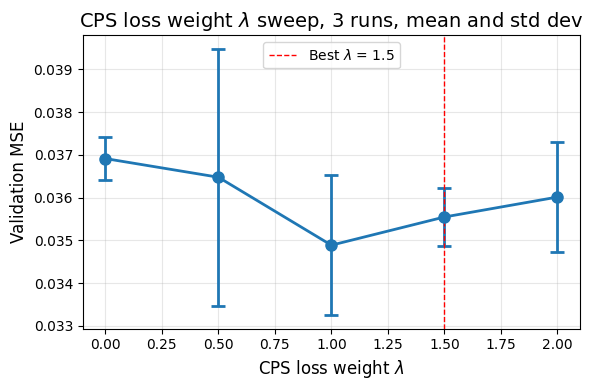

In [6]:
df = pd.read_csv(STATS_DIR_CLEAN / "ncps-gcn-n2-cps-loss-weight-sweep.csv", quotechar="\"")

grouped = df.groupby("cps_loss_weight")["val_mse"].agg(["mean", "std"]).reset_index()
grouped["score"] = grouped["mean"] + grouped["std"]
# print(grouped)
# Plot with error bars
fig, ax = plt.subplots(figsize=(6, 4), layout="tight")
ax.errorbar(
    grouped["cps_loss_weight"], 
    grouped["mean"], 
    yerr=grouped["std"],
    fmt="o-",
    capsize=5,
    capthick=2,
    markersize=8,
    linewidth=2,
)
best_val = grouped.loc[grouped["score"].idxmin()]["cps_loss_weight"]
ax.axvline(best_val, c="red", linestyle="--", linewidth=1, label=rf"Best $\lambda$ = {best_val}")

ax.set_xlabel(r"CPS loss weight $\lambda$", fontsize=12)
ax.set_ylabel("Validation MSE", fontsize=12)
ax.set_title(r"CPS loss weight $\lambda$ sweep, 3 runs, mean and std dev", fontsize=14)
ax.grid(True, alpha=0.3)
ax.legend()
plt.savefig(FIGURES_DIR / "ncps-gcn-n2-cps-loss-weight-sweep.png")
# plt.savefig(FIGURES_DIR / "ncps-gcn-n2-cps-loss-weight-sweep2.png", dpi=300, bbox_inches="tight")

### n-CPS n=3 lambda determination

Collecting data from wandb:

In [7]:
runs = api.runs(
    "DL-gr82/semi-supervised-ensembles",
    filters={
        "tags": "ncps-gcn-n3-lambda-sweep",
        "state": "finished"
    }
)

# Extract data
data = []
print(f"Runs found: {len(runs)}")
for run in runs:
    opt = run.config["trainer"]["init"]["optimizer"]
    # Handle when it"s a list (there"s always only one item)
    if not isinstance(opt, dict):
        if len(opt) != 1:
            raise ValueError("Found multiple optimizers, aborting")
        opt = opt[0]

    data.append({
        "run_id": run.id,
        "run_name": run.name,
        "seed": run.config["seed"],
        "val_mse": run.summary["val_MSE"],
        "model": run.config["model"]["init"]["_target_"],
        "cps_loss_weight": run.config["trainer"]["init"]["cps_loss_weight"],
        "lr": opt["lr"],
        "weight_decay": opt["weight_decay"],
        "num_models": run.config["trainer"]["num_models"],
    })
df = pd.DataFrame(data)
out = STATS_DIR_CLEAN / "ncps-gcn-n3-cps-loss-weight-sweep.csv"
df.to_csv(out)

Runs found: 8


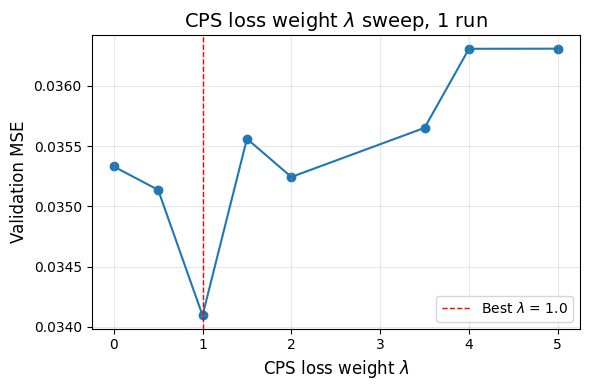

In [8]:
df = pd.read_csv(STATS_DIR_CLEAN / "ncps-gcn-n3-cps-loss-weight-sweep.csv", quotechar="\"")

grouped = df.groupby("cps_loss_weight")["val_mse"].agg(["mean", "std"]).reset_index()
grouped["score"] = grouped["mean"] + grouped["std"]
fig, ax = plt.subplots(figsize=(6, 4), layout="tight")
# ax.errorbar(
#     grouped["cps_loss_weight"], 
#     grouped["mean"], 
#     yerr=grouped["std"],
#     fmt="o-",
#     capsize=5,
#     capthick=2,
#     markersize=8,
#     linewidth=2,
# )
ax.scatter(grouped["cps_loss_weight"], grouped["mean"])
ax.plot(grouped["cps_loss_weight"], grouped["mean"])
# best_val = grouped.loc[grouped["score"].idxmin()]["cps_loss_weight"]
best_val = grouped.loc[grouped["mean"].idxmin()]["cps_loss_weight"]
ax.axvline(best_val, c="red", linestyle="--", linewidth=1, label=rf"Best $\lambda$ = {best_val}")

ax.set_xlabel(r"CPS loss weight $\lambda$", fontsize=12)
ax.set_ylabel("Validation MSE", fontsize=12)
ax.set_title(r"CPS loss weight $\lambda$ sweep, 1 run", fontsize=14)
ax.grid(True, alpha=0.3)
ax.legend()
plt.savefig(FIGURES_DIR / "ncps-gcn-n3-cps-loss-weight-sweep.png")

### n-CPS n=3 with more unlabeled data

Collecting data from wandb:

In [9]:
runs = api.runs(
    "DL-gr82/semi-supervised-ensembles",
    filters={
        "tags": "ncps-gcn-n3-more-unlabeled",
        "state": "finished"
    }
)

# Extract data
data = []
print(f"Runs found: {len(runs)}")
for run in runs:
    opt = run.config["trainer"]["init"]["optimizer"]
    # Handle when it"s a list (there"s always only one item)
    if not isinstance(opt, dict):
        if len(opt) != 1:
            raise ValueError("Found multiple optimizers, aborting")
        opt = opt[0]

    data.append({
        "run_id": run.id,
        "run_name": run.name,
        "seed": run.config["seed"],
        "val_mse": run.summary["val_MSE"],
        "model": run.config["model"]["init"]["_target_"],
        "cps_loss_weight": run.config["trainer"]["init"]["cps_loss_weight"],
        "lr": opt["lr"],
        "weight_decay": opt["weight_decay"],
        "num_models": run.config["trainer"]["num_models"],
        "total_epochs": run.config["trainer"]["train"]["total_epochs"],
        "labeled_to_unlabeled_ratio": run.config["dataset"]["init"]["labeled_to_unlabeled_ratio"],
    })
df = pd.DataFrame(data)
out = STATS_DIR_CLEAN / "ncps-gcn-n3-more-unlabeled.csv"
df.to_csv(out)

Runs found: 12


    seed   val_mse  labeled_to_unlabeled_ratio  total_epochs
0      0  0.034178                       0.125           500
4      1  0.035319                       0.125           500
8      2  0.035994                       0.125           500
5      1  0.035489                       0.250           500
9      2  0.035082                       0.250           500
2      0  0.035605                       0.250           500
6      1  0.037645                       0.500           500
1      0  0.034552                       0.500           500
10     2  0.036261                       0.500           500
3      0  0.033981                       1.000           500
7      1  0.035442                       1.000           500
11     2  0.036125                       1.000           500
   labeled_to_unlabeled_ratio      mean       std  count     score
0                       0.125  0.035164  0.000918      3  0.036082
1                       0.250  0.035392  0.000275      3  0.035667
2     

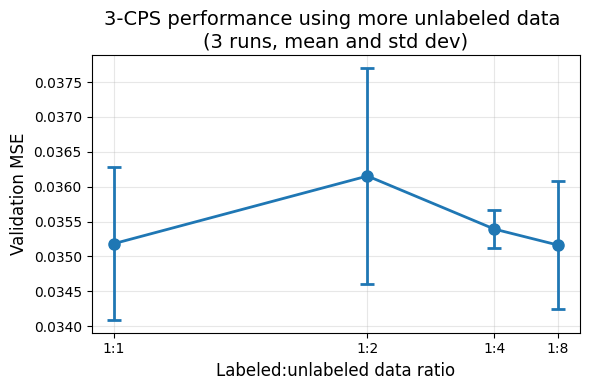

In [10]:
df = pd.read_csv(STATS_DIR_CLEAN / "ncps-gcn-n3-more-unlabeled.csv", quotechar="\"")
df = df[df["cps_loss_weight"] == 1]
print(df[["seed","val_mse", "labeled_to_unlabeled_ratio","total_epochs"]].sort_values(by="labeled_to_unlabeled_ratio"))
grouped = df.groupby("labeled_to_unlabeled_ratio")["val_mse"].agg(["mean", "std", "count"]).reset_index()
grouped["score"] = grouped["mean"] + grouped["std"]
print(grouped)
# Plot with error bars
fig, ax = plt.subplots(figsize=(6, 4), layout="tight")
ax.errorbar(
    grouped["labeled_to_unlabeled_ratio"], 
    grouped["mean"], 
    yerr=grouped["std"],
    fmt="o-",
    capsize=5,
    capthick=2,
    markersize=8,
    linewidth=2,
)
ax.xaxis.set_inverted(True)
labels = [f"1:{1/r:.0f}" for r in grouped["labeled_to_unlabeled_ratio"]]
ax.set_xticks(grouped["labeled_to_unlabeled_ratio"], labels)
ax.set_xlabel(r"Labeled:unlabeled data ratio", fontsize=12)
ax.set_ylabel("Validation MSE", fontsize=12)
# n_runs = grouped["count"].unique()
ax.set_title(f"3-CPS performance using more unlabeled data \n(3 runs, mean and std dev)", fontsize=14)
ax.grid(True, alpha=0.3)
plt.savefig(FIGURES_DIR / "ncps-gcn-n3-more-unlabeled.png")
# plt.savefig(FIGURES_DIR / "ncps-gcn-n3-more-unlabeled2.png", dpi=300, bbox_inches="tight")